This file covers the process of data selection for Artemis based upon the satelite's position in comparison to the Earth and Moon.

After completing the process of filtering out invalid values and resampling on an hourly timescale, we are still seeing daily and monthly dips in the solar wind speed for the Artemis mission. This code is going to use the position of Artemis in comparison to the Moon and the Earth in order to filter out these dips.

First we need to import the two CSV files, one for the solar wind data and one for the position data and merge them based on time.

In [11]:
import numpy as np
import pandas as pd
import datetime
posFrame = pd.read_csv('ArtemisP2.csv')
windFrame = pd.read_csv('ArtemisSW2.csv')
windFrame = windFrame.loc[:, ~windFrame.columns.str.contains('^Unnamed')]
posFrame = posFrame.loc[:, ~posFrame.columns.str.contains('^Unnamed')]
windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])
windFrame['date'] = pd.to_datetime(windFrame['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'])
posFrame['date'] = pd.to_datetime(posFrame['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ']).dt.date
mergedFrame = pd.merge(windFrame, posFrame, on='date')
mergedFrame = mergedFrame.drop(['date', 'EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'], axis=1)
mergedFrame = mergedFrame[mergedFrame.IonDensityN_cc != -1.0E+31]
#mergedFrame.to_csv(r'ArtemisMerged2.csv')

Now we have a merged dataset that includes time, ion density, ion speed, and position relative to the Sun, Moon, and Earth

<Figure size 432x288 with 0 Axes>

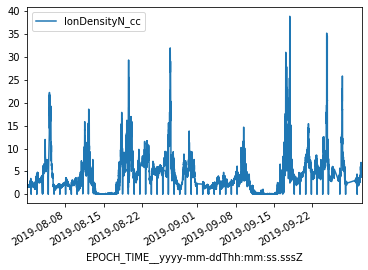

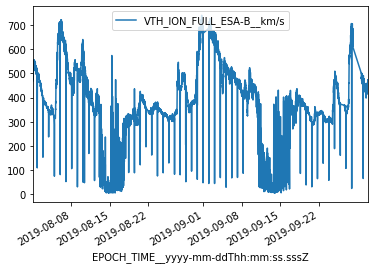

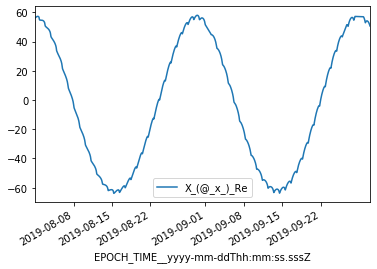

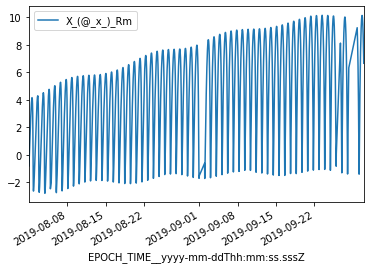

In [14]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle("Artemis velocity and position data")

df = pd.read_csv('ArtemisMerged2.csv')
df['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])
df.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='IonDensityN_cc')
df.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='VTH_ION_FULL_ESA-B__km/s')
df.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='X_(@_x_)_Re')
df.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='X_(@_x_)_Rm')


As you can see from the first position plot for the Earth's orbit, and the second plot for the Moon's orbit we should be able to filter out these dips by filtering out values under -50 for the Earth's orbit and -.5 for the Moon's orbit. We will also resample the data at an hourly timescale.

<Figure size 432x288 with 0 Axes>

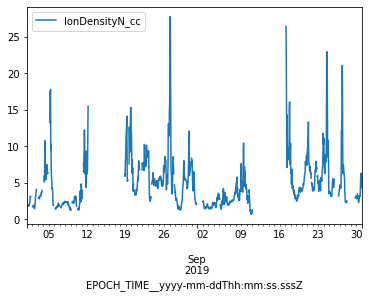

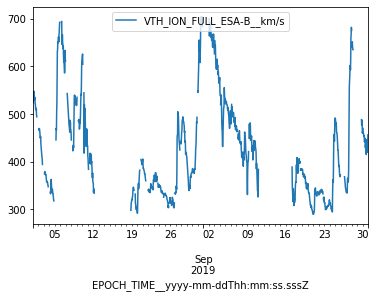

In [21]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle("Artemis velocity and position data")

df = pd.read_csv('ArtemisMerged2.csv')
df['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])
df = df[df['X_(@_x_)_Re'] >= -50]
df = df[df['X_(@_x_)_Rm'] >= 0]

df = df.resample('H', on = 'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

df.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='IonDensityN_cc')
df.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='VTH_ION_FULL_ESA-B__km/s')


There are some gaps in the data now, but we can be sure that it is not being influenced by celstial bodies that are in the way of the solar wind. From here we can compare to the OMNI dataset to see how close the data is.

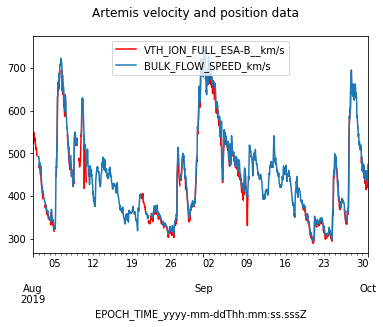

In [5]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle("Artemis velocity and position data")

df = pd.read_csv('ArtemisMerged2.csv')
df['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])
df = df[df['X_(@_x_)_Re'] >= -35]
df = df[df['X_(@_x_)_Rm'] >= 0]

df = df.resample('H', on = 'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

df2 = pd.read_csv('Omni4Artemis2.csv')
df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'])
df2 = df2[df2['ION_DENSITY_N/cm3'] != -1.0E+31]
df2 = df2.resample('H', on = 'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

ax = plt.gca()
ay = plt.gca()
df.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='VTH_ION_FULL_ESA-B__km/s', color='red', ax=ax)
df2.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='BULK_FLOW_SPEED_km/s', ax=ax)
#df.plot(kind='line', x='EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ', y='IonDensityN_cc', color='red', ax=ay)
#df2.plot(kind='line', x='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', y='ION_DENSITY_N/cm3',  ax=ay)
ax.set_xlim([datetime.date(2019, 8, 1), datetime.date(2019, 10, 1)])

plt.show()

As you can see, there are now gaps in the data on a daily and monthly basis, but the remaining data is fairly close to what the OMNI dataset has for similar time intervals. When we figure out an appropriate time shift, we should be able to merge these two sets and be left with the data points where there is only data for both datasets.

In [2]:
import numpy as np
import pandas as pd
import datetime

df = pd.read_csv('csv files/ArtemisMerged2.csv')
df['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'])
df = df[df['X_(@_x_)_Re'] >= -35]
df = df[df['X_(@_x_)_Rm'] >= 0]
df = df.resample('H', on = 'EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

df2 = pd.read_csv('csv files/Omni4Artemis2.csv')
df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'] = pd.to_datetime(df2['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'])
df2 = df2[df2['ION_DENSITY_N/cm3'] != -1.0E+31]
df2 = df2.resample('H', on = 'EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ').mean().reset_index()

df = df.drop(['X_(@_x_)_Re', 'Y_(@_y_)_Re', 'Z_(@_z_)_Re', 'X_(@_x_)_Rm', 'Y_(@_y_)_Rm', 'Z_(@_z_)_Rm','Unnamed: 0'], axis=1)
df['new_time'] = df['EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ'] - pd.Timedelta(hours = 1)
df['Time_offset_hours'] = 1

mF = pd.merge(df2, df, how='right', left_on='EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ', right_on='new_time')
mF = mF.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

mF.rename(columns = {'IonDensityN_cc':'ArtemisIonDensityN_CC',
                     'VTH_ION_FULL_ESA-B__km/s':'ArtemisIonSpeedKM_S',
                     'RAD_AU_AU':'ArtemisDistanceAU',
                     'HGI_LAT_deg':'ArtemisLatDeg',
                     'HGI_LON_deg':'ArtemisLonDeg'}, inplace = True)

mF.rename(columns = {'HELIOGRAPHIC_LATITUDE_deg':'OMNILatDeg',
                     'HELIOGRAPHIC_LONGITUDE_deg':'OMNILonDeg',
                     'BULK_FLOW_SPEED_km/s':'OMNIIonSpeedKM_S',
                     'ION_DENSITY_N/cm3':'OMNIIonDensityN_CC'}, inplace = True)
#mF.to_csv('FinalArtemisData.csv')
mF.head()

EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ  OMNILatDeg  OMNILonDeg  \
2           2019-08-02 01:00:00+00:00         5.7       232.1   
3           2019-08-02 02:00:00+00:00         5.7       232.1   
4           2019-08-02 03:00:00+00:00         5.7       232.1   
5           2019-08-02 04:00:00+00:00         5.7       232.2   
6           2019-08-02 05:00:00+00:00         5.7       232.2   

   OMNIIonSpeedKM_S  OMNIIonDensityN_CC EPOCH_TIME__yyyy-mm-ddThh:mm:ss.sssZ  \
2             489.0                 2.5            2019-08-02 02:00:00+00:00   
3             489.0                 2.2            2019-08-02 03:00:00+00:00   
4             470.0                 1.9            2019-08-02 04:00:00+00:00   
5             474.0                 2.0            2019-08-02 05:00:00+00:00   
6             478.0                 1.9            2019-08-02 06:00:00+00:00   

   ArtemisIonDensityN_CC  ArtemisIonSpeedKM_S  ArtemisDistanceAU  \
2               1.805000           469.300000               1.01   
3               1.658571           465.642857               1.01   
4               1.645000           466.883333               1.01   
5               1.687143           468.685714               1.01   
6               1.712857           463.842857               1.01   

   ArtemisLatDeg  ArtemisLonDeg                  new_time  Time_offset_hours  
2            5.8          233.2 2019-08-02 01:00:00+00:00                  1  
3            5.8          233.2 2019-08-02 02:00:00+00:00                  1  
4            5.8          233.2 2019-08-02 03:00:00+00:00                  1  
5            5.8          233.2 2019-08-02 04:00:00+00:00                  1  
6            5.8          233.2 2019-08-02 05:00:00+00:00                  1